In [1]:
%pip install statsmodels

Defaulting to user installation because normal site-packages is not writeableNote: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Program Files (x86)\Microsoft Visual Studio\Shared\Python39_64\python.exe -m pip install --upgrade pip' command.


In [2]:
from src.utils import astype_to_category, convert_category_into_integer
from src.model.decision_tree import decision_tree
from src.model.logistic_regression import logit
from src.model.svm import *

import pandas as pd
import numpy as np
import random
from tqdm import tqdm

from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.datasets as ds
import torchvision.transforms as transforms

import lightning as L
from lightning.pytorch.trainer import Trainer
from lightning.pytorch.callbacks.early_stopping import EarlyStopping

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, BaggingClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report

import warnings

13793

DroppedCalls
0.0      2474
0.3      1017
0.7       966
1.0       848
1.3       780
         ... 
37.7        1
126.3       1
24.3        1
41.3        1
32.7        1
Name: count, Length: 127, dtype: int64

<Axes: xlabel='Churn', ylabel='DroppedCalls'>

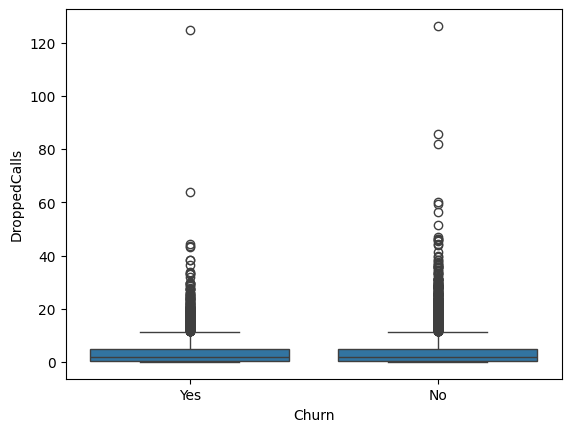

In [3]:
## 경고 무시
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
## train, test 데이터 불러오기
origin_train = pd.read_csv('../data/train.csv', encoding='cp949').dropna()
origin_test = pd.read_csv('../data/test.csv', encoding='cp949')
drop_columns = ['HandsetRefurbished', 'HandsetWebCapable', 'ServiceArea', 'ChildrenInHH', 'TruckOwner', 'RVOwner', 'Homeownership', 'BuysViaMailOrder', 'RespondsToMailOffers', 'OptOutMailings', 'NonUSTravel', 'OwnsComputer', 'HasCreditCard', 'NewCellphoneUser', 'NotNewCellphoneUser', 'NonUSTravel', 'MadeCallToRetentionTeam', 'OwnsMotorcycle', 'CreditRating', 'MaritalStatus', 'Occupation', 'PrizmCode']
origin_train = origin_train.drop(columns=drop_columns)
origin_test = origin_test.drop(columns=drop_columns)
# filter_columns = ['Churn', 'MonthlyRevenue', 'TotalRecurringCharge', 'PercChangeRevenues', 'IncomeGroup', 'MonthlyMinutes', 'DroppedCalls',\
#                    'BlockedCalls', 'OverageMinutes', 'RoamingCalls', 'CustomerCareCalls', 'RetentionCalls', 'MonthsInService',\
#                       'HandsetRefurbished', 'HandsetWebCapable', 'Homeownership', 'NewCellphoneUser', 'AgeHH1', \
#                         'AgeHH2', 'CreditRating', 'AdjustmentsToCreditRating', 'HasCreditCard']
# origin_train = origin_train.filter(items=filter_columns)
# origin_train = origin_train.filter(items=filter_columns)

origin_train = origin_train.query("MonthlyRevenue < 100")
origin_train = origin_train.query("MonthlyMinutes < 1200")
origin_train = origin_train.query("OverageMinutes < 20")
origin_train = origin_train.query("-10 < PercChangeRevenues < 0")
origin_train = origin_train.query("ActiveSubs < 6")
origin_train = origin_train.query("HandsetModels < 4")
origin_train = origin_train.query("MonthsInService < 50")
origin_train = origin_train.query("CustomerCareCalls < 15")
# origin_train = origin_train.query("DroppedCalls < 15")
display(len(origin_train))
# display(origin_train.columns.unique())
display(origin_train.DroppedCalls.value_counts())
display(sns.boxplot(origin_train, y='DroppedCalls', x='Churn'))
# display(origin_train.describe())
train = origin_train
test = origin_test
objects = []
train.dtypes
for idx in range(len(train.columns)):
    if train.dtypes[idx] == object:
        objects.append(train.columns[idx])
# print(objects)

## 범주형 변수 인코딩하기
train, _ = convert_category_into_integer(train, objects)
test, _ = convert_category_into_integer(test, objects)

## 데이터 종류가 object인 칼럼을 카테고리화 하기
train = astype_to_category(train)
test = astype_to_category(test)
## 타겟 변수 정의
target = 'Churn'
# display(train.columns.unique())
## train 데이터 분할하기
seed = 0
train, valid = train_test_split(train, test_size=0.4, random_state=seed)
# print(len(train), len(valid), len(test))
## 특성 스케일링
compare_columns = train.columns.difference(objects)
standard_scaler = StandardScaler()
train.loc[:, compare_columns] = standard_scaler.fit_transform(train.loc[:, compare_columns])
valid.loc[:, compare_columns] = standard_scaler.transform(valid.loc[:, compare_columns])
test.loc[:, compare_columns] = standard_scaler.transform(test.loc[:, compare_columns])

train = pd.DataFrame(train, columns=origin_train.columns)

13793

DroppedCalls
0.0      2474
0.3      1017
0.7       966
1.0       848
1.3       780
         ... 
37.7        1
126.3       1
24.3        1
41.3        1
32.7        1
Name: count, Length: 127, dtype: int64

<Axes: xlabel='Churn', ylabel='DroppedCalls'>

svc rbf  0.760
svc rbf  0.760
Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END ...................C=0.53, coef0=2.9000000000000004; total time=   0.0s
[CV] END ...................C=0.53, coef0=2.9000000000000004; total time=   0.0s
[CV] END ...................C=0.53, coef0=2.9000000000000004; total time=   0.0s
[CV] END ...................C=0.53, coef0=2.9000000000000004; total time=   0.0s
[CV] END ...................C=0.53, coef0=2.9000000000000004; total time=   0.0s
[CV] END ...................C=0.51, coef0=0.6000000000000001; total time=   0.0s
[CV] END ...................C=0.51, coef0=0.6000000000000001; total time=   0.0s
[CV] END ...................C=0.51, coef0=0.6000000000000001; total time=   0.0s
[CV] END ...................C=0.51, coef0=0.6000000000000001; total time=   0.0s
[CV] END ...................C=0.51, coef0=0.6000000000000001; total time=   0.0s
[CV] END ..................................C=0.32, coef0=2.1; total time=   0.0s
[CV] END .........

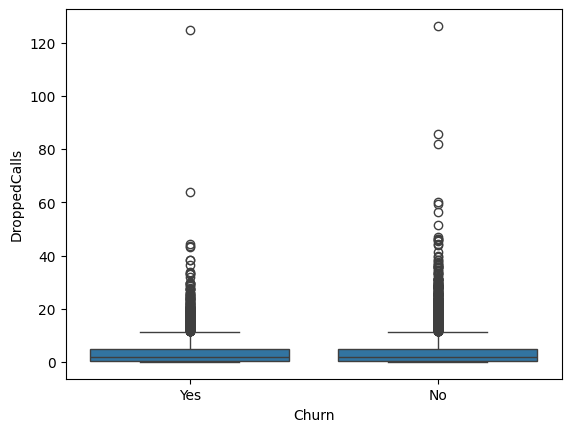

In [4]:
## 경고 무시
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
## train, test 데이터 불러오기
origin_train = pd.read_csv('../data/train.csv', encoding='cp949').dropna()
origin_test = pd.read_csv('../data/test.csv', encoding='cp949')
drop_columns = ['HandsetRefurbished', 'HandsetWebCapable', 'ServiceArea', 'ChildrenInHH', 'TruckOwner', 'RVOwner', 'Homeownership', 'BuysViaMailOrder', 'RespondsToMailOffers', 'OptOutMailings', 'NonUSTravel', 'OwnsComputer', 'HasCreditCard', 'NewCellphoneUser', 'NotNewCellphoneUser', 'NonUSTravel', 'MadeCallToRetentionTeam', 'OwnsMotorcycle', 'CreditRating', 'MaritalStatus', 'Occupation', 'PrizmCode']
origin_train = origin_train.drop(columns=drop_columns)
origin_test = origin_test.drop(columns=drop_columns)
# filter_columns = ['Churn', 'MonthlyRevenue', 'TotalRecurringCharge', 'PercChangeRevenues', 'IncomeGroup', 'MonthlyMinutes', 'DroppedCalls',\
#                    'BlockedCalls', 'OverageMinutes', 'RoamingCalls', 'CustomerCareCalls', 'RetentionCalls', 'MonthsInService',\
#                       'HandsetRefurbished', 'HandsetWebCapable', 'Homeownership', 'NewCellphoneUser', 'AgeHH1', \
#                         'AgeHH2', 'CreditRating', 'AdjustmentsToCreditRating', 'HasCreditCard']
# origin_train = origin_train.filter(items=filter_columns)
# origin_train = origin_train.filter(items=filter_columns)

origin_train = origin_train.query("MonthlyRevenue < 100")
origin_train = origin_train.query("MonthlyMinutes < 1200")
origin_train = origin_train.query("OverageMinutes < 20")
origin_train = origin_train.query("-10 < PercChangeRevenues < 0")
origin_train = origin_train.query("ActiveSubs < 6")
origin_train = origin_train.query("HandsetModels < 4")
origin_train = origin_train.query("MonthsInService < 50")
origin_train = origin_train.query("CustomerCareCalls < 15")
# origin_train = origin_train.query("DroppedCalls < 15")
display(len(origin_train))
# display(origin_train.columns.unique())
display(origin_train.DroppedCalls.value_counts())
display(sns.boxplot(origin_train, y='DroppedCalls', x='Churn'))
# display(origin_train.describe())
train = origin_train
test = origin_test
objects = []
train.dtypes
for idx in range(len(train.columns)):
    if train.dtypes[idx] == object:
        objects.append(train.columns[idx])
# print(objects)

## 범주형 변수 인코딩하기
train, _ = convert_category_into_integer(train, objects)
test, _ = convert_category_into_integer(test, objects)

## 데이터 종류가 object인 칼럼을 카테고리화 하기
train = astype_to_category(train)
test = astype_to_category(test)
## 타겟 변수 정의
target = 'Churn'
# display(train.columns.unique())
## train 데이터 분할하기
seed = 0
train, valid = train_test_split(train, test_size=0.4, random_state=seed)
# print(len(train), len(valid), len(test))
## 특성 스케일링
compare_columns = train.columns.difference(objects)
standard_scaler = StandardScaler()
train.loc[:, compare_columns] = standard_scaler.fit_transform(train.loc[:, compare_columns])
valid.loc[:, compare_columns] = standard_scaler.transform(valid.loc[:, compare_columns])
test.loc[:, compare_columns] = standard_scaler.transform(test.loc[:, compare_columns])

train = pd.DataFrame(train, columns=origin_train.columns)
# df_train.corr()

# logit(target, train, valid, seed, compare_columns)
# decision_tree(target, train, test, seed)
sample_size = 100
svc(target, train, valid, seed, sample_size=sample_size)
svc_tuned(target, train, valid, seed, sample_size=sample_size)
svc_tuning(target, train, valid, seed, sample_size=sample_size)

# param_grid = {
#     'C': [0.1, 1, 10, 100],
#     'gamma': [1, 0.1, 0.01, 0.001],
#     # 'coef0': np.arange(0.5, 5.1, 0.5),
# }

# grid = GridSearchCV(SVC(), param_grid, refit=True, cv=3, verbose=2)
# grid.fit(train.drop(columns=target), train[target])

,Churn,MonthlyRevenue,PercChangeRevenues,MonthlyMinutes,DroppedCalls,ActiveSubs,OverageMinutes,CustomerCareCalls,MonthsInService,HandsetModels
81,Yes,30.86,-0.9,181.0,2.3,1,0.0,6.3,49,3.0
96,No,32.27,-0.3,112.0,1.7,1,0.0,0.0,49,2.0
108,Yes,41.09,-4.1,340.0,2.7,1,6.0,1.3,49,1.0
124,Yes,56.48,-1.5,355.0,8.3,1,0.0,0.0,49,2.0
156,No,35.30,-0.3,307.0,1.0,1,0.0,0.0,48,2.0
...,...,...,...,...,...,...,...,...,...,...
50970,Yes,43.73,-1.2,218.0,5.7,2,0.0,0.0,32,1.0
50971,No,93.06,-8.1,471.0,3.7,3,18.0,0.3,35,2.0
50985,No,42.84,-3.6,154.0,3.0,1,7.0,0.3,34,2.0
50990,No,36.80,-3.6,133.0,1.7,1,0.0,0.0,35,1.0


13793

DroppedCalls
0.0      2474
0.3      1017
0.7       966
1.0       848
1.3       780
         ... 
37.7        1
126.3       1
24.3        1
41.3        1
32.7        1
Name: count, Length: 127, dtype: int64

<Axes: xlabel='Churn', ylabel='DroppedCalls'>

svc rbf  0.728
svc rbf  0.728
Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END ...................C=0.53, coef0=2.9000000000000004; total time=   1.4s
[CV] END ...................C=0.53, coef0=2.9000000000000004; total time=   1.3s
[CV] END ...................C=0.53, coef0=2.9000000000000004; total time=   1.3s
[CV] END ...................C=0.53, coef0=2.9000000000000004; total time=   1.2s
[CV] END ...................C=0.53, coef0=2.9000000000000004; total time=   1.2s
[CV] END ...................C=0.51, coef0=0.6000000000000001; total time=   1.1s
[CV] END ...................C=0.51, coef0=0.6000000000000001; total time=   1.2s
[CV] END ...................C=0.51, coef0=0.6000000000000001; total time=   1.2s
[CV] END ...................C=0.51, coef0=0.6000000000000001; total time=   1.2s
[CV] END ...................C=0.51, coef0=0.6000000000000001; total time=   1.3s
[CV] END ..................................C=0.32, coef0=2.1; total time=   1.2s
[CV] END .........

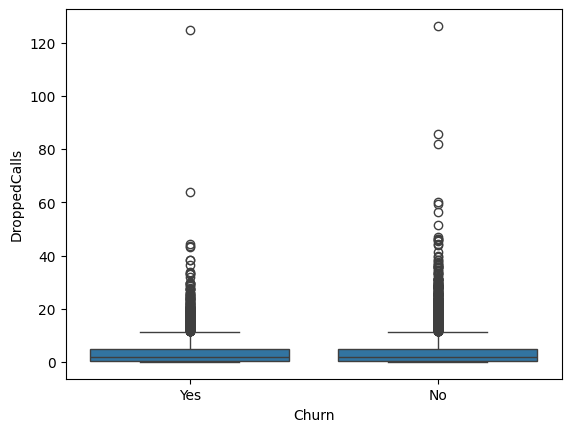

In [5]:
## 경고 무시
warnings.filterwarnings('ignore')
## train, test 데이터 불러오기
origin_train = pd.read_csv('../data/train.csv', encoding='cp949').dropna()
origin_test = pd.read_csv('../data/test.csv', encoding='cp949')
# drop_columns = ['HandsetRefurbished', 'HandsetWebCapable', 'ServiceArea', 'ChildrenInHH', 'TruckOwner', 'RVOwner', 'Homeownership', 'BuysViaMailOrder', 'RespondsToMailOffers', 'OptOutMailings', 'NonUSTravel', 'OwnsComputer', 'HasCreditCard', 'NewCellphoneUser', 'NotNewCellphoneUser', 'NonUSTravel', 'MadeCallToRetentionTeam', 'OwnsMotorcycle', 'CreditRating', 'MaritalStatus', 'Occupation', 'PrizmCode']
# origin_train = origin_train.drop(columns=drop_columns)
# origin_test = origin_test.drop(columns=drop_columns)
filter_columns = ['Churn', 'MonthlyRevenue', 'PercChangeRevenues', 'MonthlyMinutes', 'DroppedCalls', 'ActiveSubs', \
                   'OverageMinutes', 'CustomerCareCalls', 'MonthsInService', 'HandsetModels']
origin_train = origin_train.filter(items=filter_columns)
origin_test = origin_test.filter(items=filter_columns)

origin_train = origin_train.query("MonthlyRevenue < 100")
origin_train = origin_train.query("MonthlyMinutes < 1200")
origin_train = origin_train.query("OverageMinutes < 20")
origin_train = origin_train.query("-10 < PercChangeRevenues < 0")
origin_train = origin_train.query("ActiveSubs < 6")
origin_train = origin_train.query("HandsetModels < 4")
origin_train = origin_train.query("MonthsInService < 50")
origin_train = origin_train.query("CustomerCareCalls < 15")
# origin_train = origin_train.query("DroppedCalls < 15")
display(origin_train)
display(len(origin_train))
# display(origin_train.columns.unique())
display(origin_train.DroppedCalls.value_counts())
display(sns.boxplot(origin_train, y='DroppedCalls', x='Churn'))
# display(origin_train.describe())
train = origin_train
test = origin_test
objects = []
train.dtypes
for idx in range(len(train.columns)):
    if train.dtypes[idx] == object:
        objects.append(train.columns[idx])
# print(objects)

## 범주형 변수 인코딩하기
train, _ = convert_category_into_integer(train, objects)
test, _ = convert_category_into_integer(test, objects)

## 데이터 종류가 object인 칼럼을 카테고리화 하기
train = astype_to_category(train)
test = astype_to_category(test)
## 타겟 변수 정의
target = 'Churn'
# display(train.columns.unique())
## train 데이터 분할하기
seed = 0
train, valid = train_test_split(train, test_size=0.4, random_state=seed)
# print(len(train), len(valid), len(test))
## 특성 스케일링
compare_columns = train.columns.difference(objects)
standard_scaler = StandardScaler()
train.loc[:, compare_columns] = standard_scaler.fit_transform(train.loc[:, compare_columns])
valid.loc[:, compare_columns] = standard_scaler.transform(valid.loc[:, compare_columns])
test.loc[:, compare_columns] = standard_scaler.transform(test.loc[:, compare_columns])

train = pd.DataFrame(train, columns=origin_train.columns)
# df_train.corr()

# logit(target, train, valid, seed, compare_columns)
# decision_tree(target, train, test, seed)
sample_size = 0
svc(target, train, valid, seed, sample_size=sample_size)
svc_tuned(target, train, valid, seed, sample_size=sample_size)
svc_tuning(target, train, valid, seed, sample_size=sample_size)

# param_grid = {
#     'C': [0.1, 1, 10, 100],
#     'gamma': [1, 0.1, 0.01, 0.001],
#     # 'coef0': np.arange(0.5, 5.1, 0.5),
# }

# grid = GridSearchCV(SVC(), param_grid, refit=True, cv=3, verbose=2)
# grid.fit(train.drop(columns=target), train[target])